## Module import

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import datetime as dt
from datetime import date
import argparse

import matplotlib.dates as mdates

import random

import time
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn import Linear

from torch.optim import Adam
from torch.utils.data import Dataset

from sklearn.model_selection import train_test_split

from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from numpy.random import seed
from tensorflow.random import set_seed

from keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import activations
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector, BatchNormalization
from keras.optimizers import adam_v2
from keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow import convert_to_tensor, string
from tensorflow.keras.layers import TextVectorization, Embedding, Layer

import numpy as np
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.graphics.tsaplots import plot_acf

import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive/')

ImportError: cannot import name 'adam_v2' from 'keras.optimizers' (/usr/local/lib/python3.10/dist-packages/keras/optimizers/__init__.py)

**Hyperparameters**

In [ ]:
### country index for quickly change used country data
country_index = 0
country_data = {0:'america_cdc', 1:'us', 2:'india', 3:'australia', 4:'canada', 5:'germany', 6:'uk', 7:'south africa'}[country_index]


### data source -- 0: from USA CDC/JHU data; 2: from WHO; 3: from OWID
source_id = 2
data_source = {0:'cdc/jhu', 1:'who', 2:'owid'}[source_id]

### OWID doessn't have good successive data, so need smooth it (moving average)
smooth = False  # for owid

### remove some columns for CDC data
lack_index = 3  # only for cdc data
lack_index = {0:'case', 1:'death', 2:'test', 3:'full'}[lack_index]

data_version = 1
log_ind = False

if country_data == 'america_cdc':
    print('Using ' + country_data.upper() + ' lack ' + lack_index + ' data ' + 'now!')
else:
    print('Using ' + country_data.upper() + ' data from ' + data_source.upper() +' now!')

Using AMERICA_CDC lack full data now!


#**Exploration**

In [ ]:
owid[owid['location'] == 'United States'].set_index('date').loc['2021/3/2': '2022/5/15', ['new_cases', 'new_deaths', 'new_tests', 'new_vaccinations']]

In [ ]:
jud = np.abs(np.array(cdc_kk['Doses'][1:])-np.array(cdc_kk['Doses'][:-1]))
jud = np.insert(jud, 0, 0)
plt.plot(jud)

In [ ]:
cdc['Doses'][jud > 400000] = np.array((cdc['Doses'].shift(1) + cdc['Doses'].shift(-1))/2)[jud > 400000]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
cdc

,new_cases,new_deaths,new_tests,new_vaccinations,y
date,,,,,
2021/3/2,6391.0,343.0,719140.0,276310.0,347406.0
2021/3/3,6386.0,487.0,868326.0,347406.0,446450.0
2021/3/4,6573.0,242.0,1026704.0,446450.0,494235.0
2021/3/5,5948.0,236.0,992452.0,494235.0,448396.0
2021/3/6,6039.0,158.0,468764.0,448396.0,184384.0
...,...,...,...,...,...
2022/5/10,10413.0,284.0,308036.0,35272.0,36016.0
2022/5/11,8330.0,208.0,241275.0,36016.0,35034.0
2022/5/12,14800.0,186.0,267067.0,35034.0,31687.0


## plot

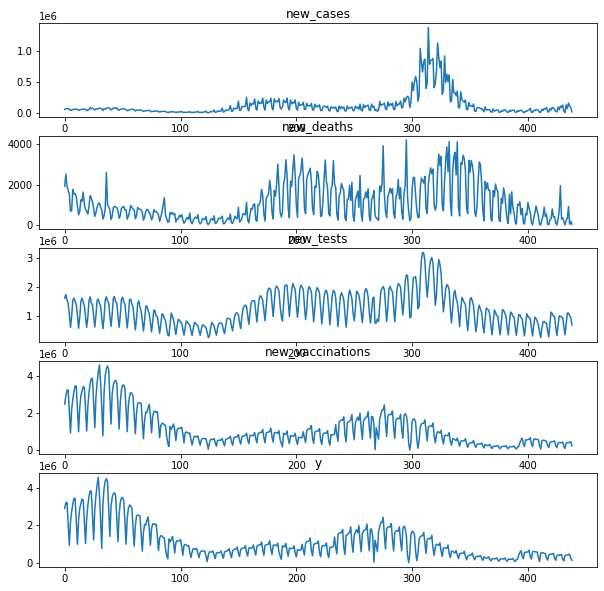

In [ ]:
fig, ax = plt.subplots(cdc.shape[1],1, figsize = (10,10))
for i in range(cdc.shape[1]):
  ax[i].plot(np.array(cdc.iloc[:,i]))
  ax[i].title.set_text(cdc.columns[i])

fig, ax = plt.subplots(cdc.shape[1],1, figsize= (10,10)
for i in range (cdc.shape[1]):
  ax[i].plot(np.array(cdc.iloc[:,i]))
  ax[i].title.set_text(cdc.columns[i])


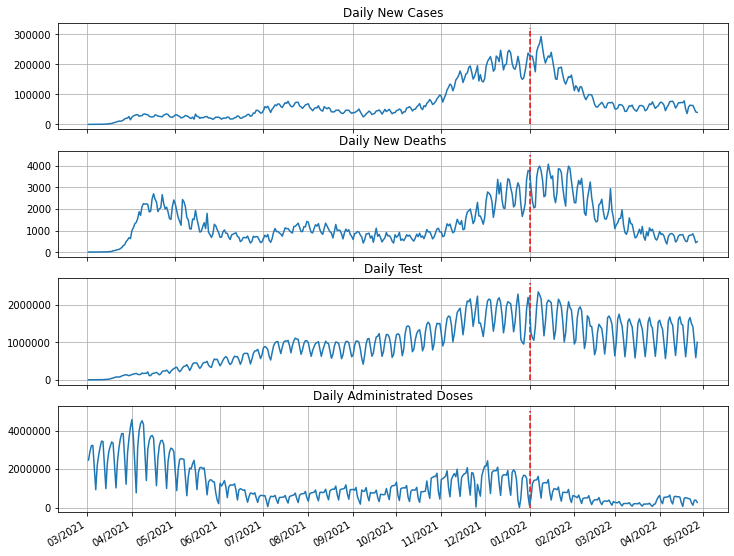

In [ ]:

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12,10))
ax1.plot(all_dates, cdc_full['New Cases'])
ax2.plot(all_dates, cdc_full['New Deaths'])
ax3.plot(all_dates, cdc_full['Daily Test Volume'])
ax4.plot(all_dates, cdc_full['Total Doses Administered Daily'])

#ax1.yticks(range(0,310000,100000))

ax1.ticklabel_format(style='plain', axis = 'y')
ax2.ticklabel_format(style='plain', axis = 'y')
ax3.ticklabel_format(style='plain', axis = 'y')
ax4.ticklabel_format(style='plain', axis = 'y')

ax1.vlines(dt.datetime(2022, 1, 1), 0, max(cdc_full['New Cases']) * 1.1, color="red", linestyles="dashed", linewidth=1.5)
ax2.vlines(dt.datetime(2022, 1, 1), 0, max(cdc_full['New Deaths']) * 1.1, color="red", linestyles="dashed", linewidth=1.5)
ax3.vlines(dt.datetime(2022, 1, 1), 0, max(cdc_full['Daily Test Volume']) * 1.1, color="red", linestyles="dashed", linewidth=1.5)
ax4.vlines(dt.datetime(2022, 1, 1), 0, max(cdc_full['Total Doses Administered Daily']) * 1.1, color="red", linestyles="dashed", linewidth=1.5)

ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
ax4.grid(True)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()

ax1.set_title('Daily New Cases')
ax2.set_title('Daily New Deaths')
ax3.set_title('Daily Test')
ax4.set_title('Daily Administrated Doses')


plt.show()

In [ ]:
def set_plot(x, y, fig, ax, color = 'blue', locator = mdates.MonthLocator(), format = '%m/%Y', subtitle = None):
    ax.plot(x, y, color = color)
    ax.ticklabel_format(style='plain', axis = 'y')
    ax.grid(True)
    ax.vlines(dt.datetime(2022, 1, 1), 0, max(y) * 1.1, color="red", linestyles="dashed", linewidth=1.5)
    ax.xaxis.set_major_formatter(mdates.DateFormatter(format))
    ax.xaxis.set_major_locator(locator)
    fig.autofmt_xdate()
    ax.set_title(subtitle)

    return ax

fig, axs = plt.subplots(4,1, figsize = (12,10))

for i, ax in enumerate(axs):
    set_plot(all_dates,
             cdc.iloc[:,i],
             fig,
             ax,
             subtitle = ['Cases', 'Deaths', 'Tests', 'Doses'][i])

In [ ]:
plot_acf(pd.read_csv('/content/drive/MyDrive/Tilburg Thesis/data/cdc_dose.csv').loc[:,['Total Doses Administered Daily']], title = None)

# Process Data

## get data

In [ ]:
number_to_predict = 1

cdc_death = pd.read_csv('/content/drive/MyDrive/Tilburg Thesis/data/cdc_death.csv').loc[::-1,:].reset_index(drop = True).loc[:,['Date', 'New Deaths']]
cdc_case = pd.read_csv('/content/drive/MyDrive/Tilburg Thesis/data/cdc_case.csv').loc[::-1,:].reset_index(drop = True).loc[:,['Date', 'New Cases']]
cdc_test = pd.read_csv('/content/drive/MyDrive/Tilburg Thesis/data/cdc_test.csv').loc[::-1,:].reset_index(drop = True).loc[:,['Date', 'Daily Test Volume']]
cdc_dose = pd.read_csv('/content/drive/MyDrive/Tilburg Thesis/data/cdc_dose.csv').loc[:,['Date', 'Total Doses Administered Daily']].iloc[40:,:].reset_index(drop = True)
cdc_full = pd.concat([cdc_death, cdc_case, cdc_test, cdc_dose], axis = 1).dropna()


cdc_full = cdc_full.loc[:,['Date', 'New Cases', 'New Deaths', 'Daily Test Volume', 'Total Doses Administered Daily']].iloc[:,3:]
cdc_full.index = cdc_full['Date']
cdc_full = cdc_full.drop('Date', axis = 1)

cdc_full['y'] = cdc_full['Total Doses Administered Daily'].shift(-1)
cdc_full = cdc_full.dropna()

owid = pd.read_csv('/content/drive/MyDrive/Tilburg Thesis/owid-covid-data.csv')

def getOwid(country_name, owid = owid, smooth = False):
    country_owid = owid[owid['location'] == country_name].copy()
    country_owid = country_owid.set_index('date')
    if not smooth:
        country_owid = country_owid.loc['2021/3/2': '2022/5/15', ['new_cases', 'new_deaths', 'new_tests', 'new_vaccinations']]
    else:
        country_owid = country_owid.loc['2021/3/2': '2022/5/15', ['new_cases_smoothed', 'new_deaths_smoothed', 'new_tests_smoothed', 'new_vaccinations_smoothed']]

    return country_owid.fillna(1)

if country_data == 'america_cdc':

    cdc_lack_case = cdc_full.drop(['New Cases'], axis = 1)
    cdc_lack_death = cdc_full.drop(['New Deaths'], axis = 1)
    cdc_lack_test = cdc_full.drop(['Daily Test Volume'], axis = 1)

    if lack_index == 'full':
      cdc = cdc_full
    elif lack_index == 'case':
      cdc = cdc_lack_case
    elif lack_index == 'death':
      cdc = cdc_lack_death
    elif lack_index == 'test':
      cdc = cdc_lack_test


elif country_data == 'us':

    if data_source == 'cdc/jhu':
        data_country = pd.read_csv('/content/drive/MyDrive/Tilburg Thesis/data/nation/all_data_' + country_data + '.csv', )
        data_country.index = data_country['Date']
        data_country = data_country.drop(['Date'], axis = 1)
        data_country['y'] = data_country['Doses'].shift(-1)
        data_country = data_country.dropna()
        cdc = data_country
    elif data_source == 'owid':
        cdc = getOwid('United States', smooth = smooth)
        check = cdc.copy()
        cdc['y'] = cdc['new_vaccinations'].shift(-1)
        cdc = cdc.dropna()
    else:
        raise ValueError('Unavailable data source!')


elif country_data == 'india':

    if data_source == 'cdc/jhu':
        data_country = pd.read_csv('/content/drive/MyDrive/Tilburg Thesis/data/nation/all_data_' + country_data + '.csv', )
        data_country.index = data_country['Date']
        data_country = data_country.drop(['Date'], axis = 1)
        data_country['y'] = data_country['Doses'].shift(-1)
        data_country = data_country.dropna()
        cdc = data_country

    elif data_source == 'owid':
        cdc = getOwid('India', smooth = smooth)
        check = cdc.copy()
        cdc['y'] = cdc['new_vaccinations'].shift(-1)
        cdc = cdc.dropna()
    else:
        raise ValueError('Unavailable data source!')

elif country_data == 'australia':
    if data_source == 'cdc/jhu':
        data_country = pd.read_csv('/content/drive/MyDrive/Tilburg Thesis/data/nation/all_data_' + country_data + '.csv', )
        data_country.index = data_country['Date']
        data_country = data_country.drop(['Date'], axis = 1)
        data_country['y'] = data_country['Doses'].shift(-1)
        data_country = data_country.dropna()
        cdc = data_country
    elif data_source == 'owid':
        cdc = getOwid('Australia', smooth = smooth)
        check = cdc.copy()
        cdc['y'] = cdc['new_vaccinations'].shift(-1)
        cdc = cdc.dropna()
    else:
        raise ValueError('Unavailable data source!')

elif country_data == 'canada':

    data_country = pd.read_csv('/content/drive/MyDrive/Tilburg Thesis/data/nation/all_data_' + country_data + '.csv', )
    data_country.index = data_country['Date']
    data_country = data_country.drop(['Date'], axis = 1)
    data_country['y'] = data_country['Doses'].shift(-1)
    data_country = data_country.dropna()
    cdc = data_country.copy()

    if data_source == 'who':
        world_data = pd.read_csv('/content/drive/MyDrive/Tilburg Thesis/data/world data.csv', encoding= 'unicode_escape')
        world_data = world_data[world_data['Country'] == 'Canada']
        world_data = world_data.set_index('Date_reported', drop = True)
        world_data = world_data.loc['2021/3/2':'2022/5/14',['New_cases', 'New_deaths']]

        cdc['Deaths'] = np.array(world_data['New_deaths'])
        cdc['Confirmed'] = np.array(world_data['New_cases'])

    elif data_source == 'owid':
        cdc = getOwid('Canada', smooth = smooth)
        cdc['y'] = cdc['new_vaccinations'].shift(-1)
        cdc = cdc.dropna()
    else:
        raise ValueError('Unavailable data source!')


elif country_data == 'germany':
    if data_source == 'owid':
        cdc = getOwid('Germany', smooth = smooth)
        cdc['y'] = cdc['new_vaccinations'].shift(-1)
        cdc = cdc.dropna()

    else:
        raise ValueError('Unavailable data source!')

elif country_data == 'uk':
    if data_source == 'owid':
        cdc = getOwid('United Kingdom', smooth = smooth)
        cdc['y'] = cdc['new_vaccinations'].shift(-1)
        cdc = cdc.dropna()

    else:
        raise ValueError('Unavailable data source!')

elif country_data == 'south africa':
    if data_source == 'owid':
        cdc = getOwid('South Africa', smooth = smooth)
        cdc['y'] = cdc['new_vaccinations'].shift(-1)
        cdc = cdc.dropna()

    else:
        raise ValueError('Unavailable data source!')

if log_ind:
    cdc = np.log(cdc.replace(0,1))

In [ ]:
all_dates = []
d = dt.datetime(2021, 3, 2)
for i in range(422):
    all_dates.append(d)
    d = d+dt.timedelta(days=1)

train_dates = []
d = dt.datetime(2021, 3, 2)
for i in range(306):
    train_dates.append(d)
    d = d+dt.timedelta(days=1)

test_long_dates = []
d = dt.datetime(2022, 1, 1)
for i in range(90):
    test_long_dates.append(d)
    d = d+dt.timedelta(days=1)

test_short_dates = []
d = dt.datetime(2022, 1, 1)
for i in range(31):
    test_short_dates.append(d)
    d = d+dt.timedelta(days=1)

## process data

In [ ]:
### scale the data

from sklearn.preprocessing import StandardScaler

cdc_scaler = StandardScaler()
cdc_scaler.fit(cdc)

cdc_scaled = cdc_scaler.transform(cdc)

cdc_scaled[:5,:]

array([[-1.18268274, -1.47708439, -1.68441956,  1.39052506,  1.86292661],
       [-1.18240122, -1.47050592, -1.6841352 ,  1.85560787,  2.17905625],
       [-1.18216662, -1.47379515, -1.68395641,  2.17152951,  2.20639015],
       [-1.18186945, -1.47269874, -1.68349496,  2.19884542,  0.96907138],
       [-1.18174433, -1.47379515, -1.68296369,  0.96234078, -0.23022111]])

In [ ]:
def scale_back(y, scaler = cdc_scaler):
    length = np.array(y).size
    return scaler.inverse_transform(np.hstack((np.zeros((length,cdc.shape[1]-1)), np.array(y).reshape(-1,1))))[:,-1]

def mse_unscaled(y1, y2):
    return mean_squared_error(scale_back(y1), scale_back(y2))

def mape_unscaled(y1, y2):
    return mean_absolute_percentage_error(scale_back(y1), scale_back(y2))

### v1

In [ ]:
## scaled together data

if data_version == 1:
  X_ = cdc_scaled[:,:-1]
  y_ = cdc_scaled[:,-1]

  def create_sequences(X, y, seq_length):
      xs = np.zeros([len(X)-seq_length+1, seq_length, X.shape[1]])
      ys = np.zeros([len(X)-seq_length+1])

      for i in range(len(X)-seq_length+1):
          xs[i,:,:] = X[i:(i+seq_length), :]
          ys[i] = y[i+seq_length-1]

      return xs, ys

  X, y = create_sequences(X_, y_, 14)


  X_train = X[:291, :, :]
  y_train = y[:291]

  X_test_short = X[291:322, :, :]
  y_test_short = y[291:322]
  X_test_long = X[291:381, :, :]
  y_test_long = y[291:381]


  input_shape = X_train.shape[1:]
  print(X.shape)
  print(y.shape)

(409, 14, 4)
(409,)


### v2: scaled seperately

In [ ]:
if data_version == 2:
  train_ = cdc.iloc[:303, :]
  test_long_ = cdc.iloc[303:393, :]
  test_short_ = cdc.iloc[303:334, :]

  train_scaler = StandardScaler()
  train_scaler.fit(train_)
  train_scaled = train_scaler.transform(train_)

  test_long_scaler = StandardScaler()
  test_long_scaler.fit(test_long_)
  test_long_scaled = test_long_scaler.transform(test_long_)

  test_short_scaler = StandardScaler()
  test_short_scaler.fit(test_short_)
  test_short_scaled = test_short_scaler.transform(test_short_)


  traintestshort = np.vstack([train_scaled, test_short_scaled])
  traintestlong = np.vstack([train_scaled, test_long_scaled])

  X_traintestshort = traintestshort[:,:-1]
  y_traintestshort = traintestshort[:,-1]
  X_traintestlong = traintestlong[:,:-1]
  y_traintestlong = traintestlong[:,-1]


  def create_sequences(X, y, seq_length):
      xs = np.zeros([len(X)-seq_length+1, seq_length, X.shape[1]])
      ys = np.zeros([len(X)-seq_length+1])

      for i in range(len(X)-seq_length+1):
          xs[i,:,:] = X[i:(i+seq_length), :]
          ys[i] = y[i+seq_length-1]

      return xs, ys

  X_traintestshort, y_traintestshort = create_sequences(X_traintestshort, y_traintestshort, 14)
  X_traintestlong, y_traintestlong = create_sequences(X_traintestlong, y_traintestlong, 14)

  X_train = X_traintestshort[:-30,:,:]
  y_train = y_traintestshort[:-30]

  X_test_short = X_traintestshort[-30:,:,:]
  y_test_short = y_traintestshort[-30:]

  X_test_long = X_traintestlong[-90:,:,:]
  y_test_long = y_traintestlong[-90:]


  input_shape = X_train.shape[1:]
  print(X_train.shape)
  print(y_train.shape)

### v3: for multi transformer

In [ ]:

if data_version == 3:
  def create_sequences_2(X, seq_length, pred_length = 3):

      dlen = len(X)-seq_length+1 - pred_length
      xs = np.zeros([dlen, seq_length, X.shape[1]])
      ys = np.zeros([dlen, pred_length, X.shape[1]])

      for i in range(dlen):
          xs[i,:,:] = X[i:(i+seq_length), :]

          ys[i,:,:] = X[i+seq_length : i+seq_length+pred_length, :]

      return xs, ys

  X_ = cdc_scaled[:,:-1]

  X, y2 = create_sequences_2(X_, 14)


  X_train = X[:291, :, :]
  y_train2 = y2[:291,:]

  X_test_short = X[291:322, :, :]
  y_test_short2 = y2[291:322,:, :]
  X_test_long = X[291:381, :, :]
  y_test_long2 = y2[291:381,:,:]


  input_shape = X_train.shape[1:]
  print(X_train.shape)
  print(y_train2.shape)

## Dataset and Dataloader

In [ ]:
class data_dataset(Dataset):
    def __init__(self, features, label):
        self.features = torch.Tensor(features)
        self.label = torch.Tensor(label)

        assert self.features.shape[0] == self.label.shape[0]

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, i):
        return (self.features[i,...], self.label[i])


train_dataset = data_dataset(X_train, y_train)
test_dataset_long = data_dataset(X_test_long, y_test_long)
test_dataset_short = data_dataset(X_test_short, y_test_short)


train_dataloader = DataLoader(train_dataset, batch_size = 1, shuffle=True)
test_dataloader_long = DataLoader(test_dataset_long, batch_size=1, shuffle=False)
test_dataloader_short = DataLoader(test_dataset_short, batch_size=1, shuffle=False)

In [ ]:
X_train_rmval = X_train[:-58, :, :]
X_val = X_train[-58:, :, :]
y_train_rmval = y_train[:-58]
y_val = y_train[-58:]

train_rmval_dataset = data_dataset(X_train_rmval, y_train_rmval)
val_dataset = data_dataset(X_val, y_val)

train_rmval_dataloader = DataLoader(train_rmval_dataset, batch_size = 1, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size = 1, shuffle=False)

# Transformer Pytorch Linear decoder

## Functions

### Embeding and Positional encoding

In [ ]:
import torch
import torch.nn as nn
import math
from torch.autograd import Variable

"""class Embedder(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embed = nn.Embedding(vocab_size, d_model)
        self.conv1d = nn.Conv1d()


    def forward(self, x):
        return self.embed(x)"""

class PositionalEncoder(nn.Module):
    def __init__(self, d_model, seq_len = 14, dropout = 0.1, device = 0):
        super().__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)
        self.device = device

        pe = torch.zeros(seq_len, d_model)
        for pos in range(seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                if i+1 <= d_model-1:
                  pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)


    def forward(self, x):

        # make embeddings relatively larger
        # x = x * math.sqrt(self.d_model)

        #add constant to embedding
        # seq_len = x.size(1)
        pe = Variable(self.pe, requires_grad=False)

        if self.device != 0:
            pe.cuda()

        x = x + pe
        return self.dropout(x)

### Norm and multihead

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()

        self.size = d_model

        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))

        self.eps = eps

    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

def attention(q, k, v, d_k, dropout=None):

    scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)

    scores = F.softmax(scores, dim=-1)

    if dropout is not None:
        scores = dropout(scores)

    output = torch.matmul(scores, v)
    return output

class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout = 0.1):
        super().__init__()

        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads

        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):

        bs = q.size(0)

        # perform linear operation and split into N heads
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)

        # transpose to get dimensions bs * N * sl * d_model
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)


        # calculate attention using function we will define next
        scores = attention(q, k, v, self.d_k, self.dropout)
        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous()\
        .view(bs, -1, self.d_model)
        output = self.out(concat)

        return output

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout = 0.1):
        super().__init__()

        # We set d_ff as a default to 2048
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x

### Encoder and Decoder

In [ ]:
import torch
import torch.nn as nn

class OneEncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x):
        x = x + self.dropout_1(self.attn(x,x,x))
        x = self.norm_1(x)
        x = x + self.dropout_2(self.ff(x))
        x = self.norm_2(x)
        return x

# build a decoder layer with two multi-head attention layers and
# one feed-forward layer
class OneDecoderLayer(nn.Module):
    def __init__(self, decoder_outer_size, decoder_inner_size, dropout=0.1):
        super().__init__()
        self.linear_1 = Linear(decoder_outer_size, decoder_inner_size)
        self.linear_2 = Linear(decoder_inner_size, decoder_outer_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, e_outputs):
        x = self.linear_1(e_outputs)
        x = self.dropout(F.relu(x))
        x = self.linear_2(x)
        return e_outputs + x


### Build models

In [ ]:
import torch
import torch.nn as nn
import copy

def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class Encoder(nn.Module):
    def __init__(self, d_model, N, heads, dropout, seq_length, device = 0):
        super().__init__()
        self.N = N
        # self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, seq_len=seq_length, dropout=dropout, device = device)
        self.layers = get_clones(OneEncoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)
    def forward(self, src):
        # x = self.embed(src)
        x = self.pe(src)
        for i in range(self.N):
            x = self.layers[i](x)
        return self.norm(x)

class Decoder(nn.Module):
    def __init__(self, d_model, N, start_size, decoder_outer_size, decoder_inner_size, dropout):
        super().__init__()
        self.N = N
        self.start_linear = nn.Linear(start_size, decoder_outer_size)
        self.layers = get_clones(OneDecoderLayer(decoder_outer_size, decoder_inner_size, dropout), N)
        self.norm = Norm(decoder_outer_size)

    def forward(self, e_outputs):
        x = self.start_linear(e_outputs)
        for i in range(self.N):
            x = self.layers[i](x)
        return self.norm(x)

class Transformer(nn.Module):
    def __init__(self, predict_size, d_model, N_encoder, N_decoder, heads, decoder_outer_size, decoder_inner_size, inner_outsize, dropout, seq_len = 14, device = 0):
        super().__init__()
        self.encoder = Encoder(d_model, N_encoder, heads, dropout, seq_len, device)
        self.decoder = Decoder(d_model, N_decoder, d_model*seq_len, decoder_outer_size, decoder_inner_size, dropout)
        self.out_1 = nn.Linear(decoder_outer_size, inner_outsize)
        self.out_2 = nn.Linear(inner_outsize, predict_size)

    def forward(self, src):
        e_outputs = self.encoder(src)
        e_outputs = torch.flatten(e_outputs)
        d_outputs = self.decoder(e_outputs)
        output = self.out_1(d_outputs)
        return self.out_2(output)


def get_model(settings):

    assert settings['d_model'] % settings['heads'] == 0
    assert settings['dropout'] < 1

    model = Transformer(settings['predict_size'], settings['d_model'],
                        settings['n_encoder_layers'], settings['n_decoder_layers'], settings['heads'], settings['decoder_outer_size'],
                        settings['decoder_inner_size'], settings['inner_outsize'], settings['dropout'], settings['seq_length'],
                        settings['device'])

    if settings['load_weights'] is not None:
        print("loading pretrained weights...")
        model.load_state_dict(torch.load(settings['load_weights']))
    else:
        for p in model.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    if settings['device'] != 0:
        model = model.cuda()

    return model

### train function

In [ ]:
def train_model(model, settings, train_loader, val_loader = None):

    if settings['device'] != 0:
        assert torch.cuda.is_available()

    print("training model...")

    start = time.time()
    if settings['checkpoint'] > 0:
        cptime = time.time()

    optimizer = torch.optim.Adam(model.parameters(), lr = settings['lr'], betas=(0.9, 0.98), eps=1e-9)
    loss_function = nn.MSELoss()

    train_loss_list = []
    val_loss_list = []
    if val_loader is not None:
        y_val_list = []
        for _, y_ in val_loader:
            y_val_list.append(y_)
        y_val_list = np.array(y_val_list)

        y_train_list = []
        for _, y_ in train_loader:
            y_train_list.append(y_)
        y_train_list = np.array(y_train_list)



    for epoch in range(settings['epochs']):
        model.train() # train mode

        total_loss = 0
        if settings['report']:
            print("   %dm: epoch %d [%s]  %d%%  loss = %s" % ((time.time() - start)//60, epoch + 1, "".join(' '*20), 0, '...'), end='\r')

        if settings['checkpoint'] > 0:
            torch.save(model.state_dict(), '/content/weights/model_weights')

        for i, batch in enumerate(train_loader):

            src = batch[0].mean(axis = 0).unsqueeze(0)  # shape (1,14,4)
            trg = batch[1].mean(axis = 0).unsqueeze(0)  # shape (1,1)

            preds = model(src)
            ys = trg.squeeze()

            optimizer.zero_grad()

            loss = F.mse_loss(preds, ys)
            loss.backward()
            optimizer.step()


            total_loss += loss.item()

            if (i + 1) % settings['print_intervals'] == 0:
                 p = int(100 * (i + 1) / len(train_loader))
                 avg_loss = total_loss / settings['print_intervals']
                 if settings['report']:
                    print("   %dm: epoch %d [%s%s]  %d%%  loss = %.3f" % ((time.time() - start)//60, epoch + 1, "".join('#'*(p//5)), "".join(' '*(20-(p//5))), p, avg_loss), end='\r')
                 else:
                    pass
                 total_loss = 0

            if settings['checkpoint'] > 0 and ((time.time()-cptime)//60) // settings['checkpoint'] >= 1:
                torch.save(model.state_dict(), 'weights/model_weights')
                cptime = time.time()

        if val_loader is not None:
            model.eval()
            pred_y = pred(model, val_loader)
            pred_train_y = pred(model, train_loader)

            val_loss = mean_squared_error(pred_y, y_val_list)
            val_loss_list.append(val_loss)
            print('Val Loss of epoch', epoch, 'is', val_loss)

            train_loss = mean_squared_error(pred_train_y, y_train_list)
            train_loss_list.append(train_loss)
            print('Train Loss of epoch', epoch, 'is', train_loss)



        print("%dm: epoch %d [%s%s]  %d%%  loss = %.3f\nepoch %d complete, loss = %.03f" % ((time.time() - start)//60, epoch + 1, "".join('#'*(100//5)), "".join(' '*(20-(100//5))), 100, avg_loss, epoch + 1, avg_loss))

    if val_loader is not None:
        return model, np.array(train_loss_list), np.array(val_loss_list)
    else:
        return model


### pred function

In [ ]:
def pred(model, test_loader, device = 0):
    model.eval()

    pred_list = []
    sumup = 0
    for i, batch in enumerate(test_loader):
        src = batch[0].mean(axis = 0).unsqueeze(0)  # shape (1,14,4)
        trg = batch[1].mean(axis = 0).unsqueeze(0)  # shape (1,3,4)

        preds = list(model(src).detach().numpy())

        pred_list.append(preds)

    return np.array(pred_list)

## Training

### tuning

In [ ]:
result_list = []

for heads in [2,4]:
    for decoder_outer_size in [8]:
        for decoder_inner_size in [8]:

            setting_list = {'d_model': cdc.shape[1]-1, # data dimensions
                      'n_encoder_layers': 2,  # number of encoder
                      'n_decoder_layers': 2,  # number of decoder
                      'heads': heads,
                      'dropout': 0.1,
                      'report': True,
                      'print_intervals': 10,  # how many trains print a record
                      'checkpoint': 0,  # how many minutes save a model
                      'lr': 0.01,
                      'device': 0,
                      'predict_size': 1,  # output size
                      'seq_length': 14,
                      'load_weights': None,
                      'epochs': 200,
                      'decoder_outer_size': decoder_outer_size,  # MLP outer size
                      'decoder_inner_size': decoder_inner_size,  # MLP inner size
                      'inner_outsize': 4
                      }
            torch.manual_seed(42)
            random.seed(42)
            np.random.seed(42)

            tuning_model = get_model(setting_list)
            tuning_model = train_model(tuning_model, setting_list, train_rmval_dataloader)

            y_pred_val = pred(tuning_model, val_dataloader)
            result_mse = mean_squared_error(y_pred_val, y_val)
            result_mse_unscaled = mse_unscaled(y_pred_val, y_val)
            result_mape = mean_absolute_percentage_error(y_pred_val, y_val)
            result_mape_unscaled = mape_unscaled(y_pred_val, y_val)
            result_list.append((result_mse, result_mse_unscaled, result_mape, result_mape_unscaled, setting_list))

### Train

In [ ]:
setting_list = {'d_model': cdc.shape[1]-1, # data dimensions
          'n_encoder_layers': 2,  # number of encoder
          'n_decoder_layers': 2,  # number of decoder
          'heads': cdc.shape[1]-1,
          'dropout': 0.1,
          'report': True,
          'print_intervals': 10,  # how many trains print a record
          'checkpoint': 0,  # how many minutes save a model
          'lr': 0.01,
          'device': 0,
          'predict_size': 1,  # output size
          'seq_length': 14,
          'load_weights': None,
          'epochs': 200,
          'decoder_outer_size': 8,  # MLP outer size
          'decoder_inner_size': 8,  # MLP inner size
          'inner_outsize': 4
          }

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

transformer_model = get_model(setting_list)

transformer_model = train_model(transformer_model, setting_list, train_dataloader)

training model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


0m: epoch 1 [####################]  100%  loss = 1.145
epoch 1 complete, loss = 1.145
0m: epoch 2 [####################]  100%  loss = 0.978
epoch 2 complete, loss = 0.978
0m: epoch 3 [####################]  100%  loss = 1.192
epoch 3 complete, loss = 1.192
0m: epoch 4 [####################]  100%  loss = 0.260
epoch 4 complete, loss = 0.260
0m: epoch 5 [####################]  100%  loss = 1.462
epoch 5 complete, loss = 1.462
0m: epoch 6 [####################]  100%  loss = 0.647
epoch 6 complete, loss = 0.647
0m: epoch 7 [####################]  100%  loss = 0.950
epoch 7 complete, loss = 0.950
0m: epoch 8 [####################]  100%  loss = 1.336
epoch 8 complete, loss = 1.336
0m: epoch 9 [####################]  100%  loss = 1.001
epoch 9 complete, loss = 1.001
0m: epoch 10 [####################]  100%  loss = 1.565
epoch 10 complete, loss = 1.565
0m: epoch 11 [####################]  100%  loss = 0.521
epoch 11 complete, loss = 0.521
0m: epoch 12 [####################]  100%  loss = 

## Pred

In [ ]:

transformer_y_pred_long = pred(transformer_model, test_dataloader_long)
transformer_y_pred_short = pred(transformer_model, test_dataloader_short)

unscaled_transformer_y_pred_long = scale_back(transformer_y_pred_long)
unscaled_transformer_y_test_long = scale_back(y_test_long)
unscaled_transformer_y_pred_short = scale_back(transformer_y_pred_short)
unscaled_transformer_y_test_short = scale_back(y_test_short)

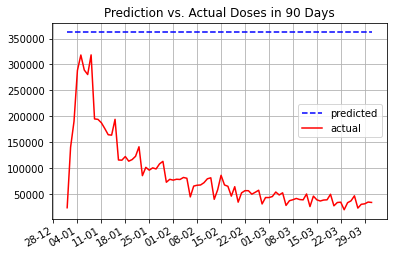

81339483750.84308
1.676509592148547
0.7626654974181493


In [ ]:
plt.plot(test_long_dates, unscaled_transformer_y_pred_long, 'b--', label = 'predicted')
plt.plot(test_long_dates, unscaled_transformer_y_test_long, 'r-', label = 'actual')


#lt.yticks(range(0, 2000000, 500000))
plt.ticklabel_format(style='plain', axis = 'y')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.gcf().autofmt_xdate()
plt.legend()
plt.title('Prediction vs. Actual Doses in 90 Days')
plt.show()


mse_unscaled_transformer_long = mse_unscaled(transformer_y_pred_long, y_test_long)
print(mse_unscaled_transformer_long)
mse_transformer_long = mean_squared_error(transformer_y_pred_long, y_test_long)
print(mse_transformer_long)

mape_transformer_long = mape_unscaled(transformer_y_pred_long, y_test_long)
print(mape_transformer_long)

In [ ]:
import matplotlib.dates as mdates

plt.plot(test_short_dates, unscaled_transformer_y_pred_short, 'b--', label = 'predicted')
plt.plot(test_short_dates, unscaled_transformer_y_test_short, 'r-', label = 'actual')

#plt.yticks(range(0, 2000000, 500000))
plt.ticklabel_format(style='plain', axis = 'y')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.gcf().autofmt_xdate()
plt.legend()
plt.title('Prediction vs. Actual Doses in 30 Days')
plt.show()


mse_unscaled_transformer_short = mse_unscaled(transformer_y_pred_short, y_test_short)
print(mse_unscaled_transformer_short)

mse_transformer_short = mean_squared_error(transformer_y_pred_short, y_test_short)
print(mse_transformer_short)
mape_transformer_short = mape_unscaled(transformer_y_pred_short, y_test_short)
print(mape_transformer_short)


In [ ]:
# save results

['america_cdc', 'us', 'india', 'australia', 'canada', 'germany', 'uk', 'south africa']
# manage epoch
epoch_lib = {'america_cdc':200,
             'us': 0,
             'india':0,
             'australia':0,
             'canada':0}


if country_data == 'america_cdc':
  file_name = 'lack_' + lack_index
else:
  file_name = country_data

if log_ind:
  log_name = '_log'
else:
  log_name = ''

if smooth:
  smooth_term = '_smoothed'
else:
  smooth_term = ''


Path = '/content/drive/MyDrive/Tilburg Thesis/results/' + file_name + log_name + smooth_term + '_' + data_source + '.csv'

# MSE_short, MSE_long, MAPE_short, MAPE_long, epoch
evaluation_list = [mse_unscaled_transformer_short,
                   mse_unscaled_transformer_long,
                   mape_transformer_short,
                   mape_transformer_long,
                   epoch_lib[country_data]]
pd.DataFrame(evaluation_list).to_csv(Path)

print('saved in '+ Path)

## Model save and load

In [ ]:
### save model
if country_data == 'america_cdc':
  file_name = 'lack_' + lack_index
else:
  file_name = country_data

if log_ind:
  log_name = '_log'
else:
  log_name = ''

if smooth:
  smooth_term = 'smoothed'
else:
  smooth_term = ''

if country_data == 'america_cdc':
  Path = '/content/drive/MyDrive/Tilburg Thesis/Model/' + file_name + log_name + smooth_term
else:
  Path = '/content/drive/MyDrive/Tilburg Thesis/Model/' + file_name + log_name + smooth_term + '_' + data_source

torch.save(transformer_model, Path)

print('saved in '+ Path)

saved in /content/drive/MyDrive/Tilburg Thesis/Model/lack_full


In [ ]:
### load model
if country_data == 'america_cdc':
  file_name = 'lack_' + lack_index
else:
  file_name = country_data

if log_ind:
  log_name = '_log'
else:
  log_name = ''

if smooth:
  smooth_term = '_smoothed'
else:
  smooth_term = ''



if country_data == 'america_cdc':
  Path = '/content/drive/MyDrive/Tilburg Thesis/Model/' + file_name + log_name + smooth_term
else:
  Path = '/content/drive/MyDrive/Tilburg Thesis/Model/' + file_name + log_name + smooth_term + '_' + data_source

transformer_model = torch.load(Path)
transformer_model.eval()

print('loaded from '+ Path)

loaded from /content/drive/MyDrive/Tilburg Thesis/Model/lack_full


# Transformer Pytorch Masked

## Functions

### Dataset and Dataloader

In [ ]:
class data_dataset(Dataset):
    def __init__(self, features, label):
        self.features = torch.Tensor(features)
        self.label = torch.Tensor(label)

        assert self.features.shape[0] == self.label.shape[0]

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, i):
        return (self.features[i,...], self.label[i,...])


train_dataset = data_dataset(X_train, y_train2)
test_dataset_long = data_dataset(X_test_long, y_test_long2)
test_dataset_short = data_dataset(X_test_short, y_test_short2)

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size = 2, shuffle=True)
test_dataloader_long = DataLoader(test_dataset_long, batch_size=1, shuffle=False)
test_dataloader_short = DataLoader(test_dataset_short, batch_size=1, shuffle=False)

### Embeding and Positional encoding

In [ ]:
import torch
import torch.nn as nn
import math
from torch.autograd import Variable

"""class Embedder(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embed = nn.Embedding(vocab_size, d_model)
        self.conv1d = nn.Conv1d()


    def forward(self, x):
        return self.embed(x)"""

class PositionalEncoder(nn.Module):
    def __init__(self, d_model, seq_len = 14, dropout = 0.1, device = 0):
        super().__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)
        self.device = device

        pe = torch.zeros(seq_len, d_model)
        for pos in range(seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)


    def forward(self, x):

        # make embeddings relatively larger
        # x = x * math.sqrt(self.d_model)

        #add constant to embedding
        # seq_len = x.size(1)
        pe = Variable(self.pe, requires_grad=False)

        if self.device != 0:
            pe.cuda()

        x = x + pe
        return self.dropout(x)

### Norm and multihead

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()

        self.size = d_model

        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))

        self.eps = eps

    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

def attention(q, k, v, d_k, mask=None, dropout=None):

    scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)

    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask == 0, -1e9)

    scores = F.softmax(scores, dim=-1)

    if dropout is not None:
        scores = dropout(scores)

    output = torch.matmul(scores, v)
    return output

class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout = 0.1):
        super().__init__()

        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads

        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):

        bs = q.size(0)

        # perform linear operation and split into N heads
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)

        # transpose to get dimensions bs * N * sl * d_model
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)


        # calculate attention using function we will define next
        scores = attention(q, k, v, self.d_k, mask, self.dropout)
        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous()\
        .view(bs, -1, self.d_model)
        output = self.out(concat)

        return output

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout = 0.1):
        super().__init__()

        # We set d_ff as a default to 2048
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x

### Encoder and Decoder

In [ ]:
import torch
import torch.nn as nn

class OneEncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x, mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x

# build a decoder layer with two multi-head attention layers and
# one feed-forward layer
class OneDecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.norm_3 = Norm(d_model)

        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)

        self.attn_1 = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.attn_2 = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)

    def forward(self, x, e_outputs, src_mask, trg_mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.attn_2(x2, e_outputs, e_outputs, src_mask))
        x2 = self.norm_3(x)
        x = x + self.dropout_3(self.ff(x2))
        return x

### Build models

In [ ]:
import torch
import torch.nn as nn
import copy

def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class Encoder(nn.Module):
    def __init__(self, d_model, N, heads, dropout, seq_length, device = 0):
        super().__init__()
        self.N = N
        # self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, seq_len=seq_length, dropout=dropout, device = device)
        self.layers = get_clones(OneEncoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)
    def forward(self, src, mask):
        # x = self.embed(src)
        x = self.pe(src)
        for i in range(self.N):
            x = self.layers[i](x, mask)
        return self.norm(x)

class Decoder(nn.Module):
    def __init__(self, d_model, N, heads, dropout, pred_length, device = 0):
        super().__init__()
        self.N = N
        # self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, pred_length, dropout=dropout, device = device)
        self.layers = get_clones(OneDecoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)
    def forward(self, trg, e_outputs, src_mask, trg_mask):
        # x = self.embed(trg)
        x = self.pe(trg)
        for i in range(self.N):
            x = self.layers[i](x, e_outputs, src_mask, trg_mask)
        return self.norm(x)

class Transformer(nn.Module):
    def __init__(self, predict_size, d_model, N, heads, dropout, seq_len = 14, device = 0):
        super().__init__()
        self.encoder = Encoder(d_model, N, heads, dropout, seq_len, device)
        self.decoder = Decoder(d_model, N, heads, dropout, predict_size, device)
        self.out = nn.Linear(d_model, predict_size)
        self.out2 = nn.Linear(predict_size ** 2, predict_size)

    def forward(self, src, trg, src_mask, trg_mask):
        e_outputs = self.encoder(src, src_mask)
        #print("DECODER")
        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        output = torch.flatten(output)
        output = self.out2(output)
        return output

def get_model(settings):

    assert settings['d_model'] % settings['heads'] == 0
    assert settings['dropout'] < 1

    model = Transformer(settings['predict_size'], settings['d_model'], settings['n_layers'], settings['heads'], settings['dropout'], settings['seq_length'], settings['device'])

    if settings['load_weights'] is not None:
        print("loading pretrained weights...")
        model.load_state_dict(torch.load(settings['load_weights']))
    else:
        for p in model.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    if settings['device'] != 0:
        model = model.cuda()

    return model

### Create mask

In [ ]:
import torch
from torchtext import data
import numpy as np
from torch.autograd import Variable


def nopeak_mask(size, device = 0):
    np_mask = np.triu(np.ones((1, size, size)), k=1).astype('uint8')
    np_mask = Variable(torch.from_numpy(np_mask) == 0)
    if device != 0:
      np_mask = np_mask.cuda()
    return np_mask

def create_masks(trg, device = 0):

    src_mask = None # (src != settings['src_pad']).unsqueeze(-2)

    if trg is not None:
        size = trg.size(1) # get seq_len for matrix
        np_mask = nopeak_mask(size, device)
        if trg.is_cuda:
            np_mask.cuda()
        trg_mask = np_mask

    else:
        trg_mask = None
    return src_mask, trg_mask


### Train

In [ ]:
def train_model(model, settings, train_loader):

    if settings['device'] != 0:
        assert torch.cuda.is_available()

    print("training model...")
    model.train() # train mode

    start = time.time()
    if settings['checkpoint'] > 0:
        cptime = time.time()

    optimizer = torch.optim.Adam(model.parameters(), lr = settings['lr'], betas=(0.9, 0.98), eps=1e-9)
    loss_function = nn.MSELoss()

    for epoch in range(settings['epochs']):

        total_loss = 0
        if settings['report']:
            print("   %dm: epoch %d [%s]  %d%%  loss = %s" % ((time.time() - start)//60, epoch + 1, "".join(' '*20), 0, '...'), end='\r')

        if settings['checkpoint'] > 0:
            torch.save(model.state_dict(), '/content/weights/model_weights')

        for i, batch in enumerate(train_loader):

            src = batch[0].mean(axis = 0).unsqueeze(0)  # shape (1,14,4)
            trg = batch[1].mean(axis = 0).unsqueeze(0)  # shape (1,3,4)

            trg_input = trg[:,:-1,:]

            src_mask, trg_mask = create_masks(trg_input, settings['device'])  # settings,device = 0 is no cuda

            src_mask = None

            preds = model(src, trg_input, src_mask, trg_mask)
            ys = trg[:, 1:, 3].squeeze()

            optimizer.zero_grad()

            loss = F.mse_loss(preds, ys)
            loss.backward()
            optimizer.step()


            total_loss += loss.item()

            if (i + 1) % settings['print_intervals'] == 0:
                 p = int(100 * (i + 1) / len(train_loader))
                 avg_loss = total_loss / settings['print_intervals']
                 if settings['report']:
                    print("   %dm: epoch %d [%s%s]  %d%%  loss = %.3f" % ((time.time() - start)//60, epoch + 1, "".join('#'*(p//5)), "".join(' '*(20-(p//5))), p, avg_loss), end='\r')
                 else:
                    pass # print("   %dm: epoch %d [%s%s]  %d%%  loss = %.3f" % ((time.time() - start)//60, epoch + 1, "".join('#'*(p//5)), "".join(' '*(20-(p//5))), p, avg_loss))
                 total_loss = 0

            if settings['checkpoint'] > 0 and ((time.time()-cptime)//60) // settings['checkpoint'] >= 1:
                torch.save(model.state_dict(), 'weights/model_weights')
                cptime = time.time()


        print("%dm: epoch %d [%s%s]  %d%%  loss = %.3f\nepoch %d complete, loss = %.03f" % ((time.time() - start)//60, epoch + 1, "".join('#'*(100//5)), "".join(' '*(20-(100//5))), 100, avg_loss, epoch + 1, avg_loss))

    return model


## Trainig start

In [ ]:
setting_list = {'d_model': 4,
          'n_layers': 2,
          'heads': 2,
          'dropout': 0.1,
          'report': True,
          'print_intervals': 10,  # how many trains print a record
          'checkpoint': 0,  # how many minutes save a model
          'lr': 0.01,
          'device': 0,
          'predict_size': 2,
          'seq_length': 14,
          'load_weights': None,
          'epochs': 200
          }

transformer_model = get_model(setting_list)
print('model setted')

model = train_model(transformer_model, setting_list, train_dataloader)

In [ ]:
def pred(model, test_loader, device = 0):

    model.eval()

    pred_list = []

    for i, batch in enumerate(test_loader):
        src = batch[0].mean(axis = 0).unsqueeze(0)  # shape (1,14,4)
        trg = batch[1].mean(axis = 0).unsqueeze(0)  # shape (1,3,4)
        trg_input = trg[:,:-1,:]

        src_mask, trg_mask = create_masks(trg_input, device)  # settings,device = 0 is no cuda
        src_mask = None

        preds = list(model(src, trg_input, src_mask, trg_mask).detach().numpy())


        if len(pred_list) == 0:
            pred_list = preds
        else:
            pred_list[-1] = (pred_list[-1] + preds[0]) * 0.5
            pred_list.append(preds[-1])

    return np.array(pred_list)

transformer_y_pred_long = pred(transformer_model, test_dataloader_long)[:-1]



In [ ]:
a.shape

(45,)

In [ ]:
for i, batch in enumerate(test_dataloader_long):
    print(batch[1])

In [ ]:
transformer_y_pred_long.shape

(90,)

In [ ]:
mse_unscaled(y_test_long, transformer_y_pred_long)

0.5425718783020952

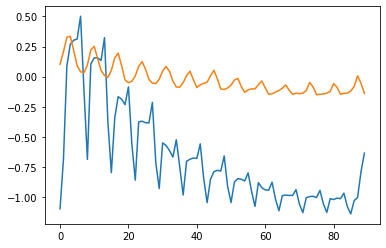

In [ ]:
plt.plot(y_test_long)
plt.plot(transformer_y_pred_long)

# VAR Baseline

In [ ]:
df = pd.DataFrame(cdc_scaled[:, :4])

df_train = df.iloc[:291, :]
df_test = df.iloc[291:322, :]
df_test_long = df.iloc[291:381, :]

df_differenced = df_train.diff().dropna()

# Check size
print(df_train.shape)
print(df_test.shape)

(291, 4)
(31, 4)


### ADF test

In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")


# ADF Test on each column
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "0" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8132
 No. Lags Chosen       = 14
 Critical value 1%     = -3.454
 Critical value 5%     = -2.872
 Critical value 10%    = -2.572
 => P-Value = 0.0564. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.9269
 No. Lags Chosen       = 13
 Critical value 1%     = -3.454
 Critical value 5%     = -2.872
 Critical value 10%    = -2.572
 => P-Value = 0.0423. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signific

### select order

In [ ]:
var_model = VAR(df_differenced)
x = var_model.select_order(maxlags=20)
x.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


,AIC,BIC,FPE,HQIC
0,-7.681,-7.628,0.0004615,-7.660
1,-8.522,-8.255,0.0001991,-8.415
2,-9.035,-8.556,0.0001191,-8.843
3,-9.268,-8.575,9.438e-05,-8.990
4,-9.427,-8.520,8.061e-05,-9.063
5,-9.566,-8.446,7.017e-05,-9.116
6,-10.45,-9.122*,2.888e-05,-9.919*
7,-10.47,-8.928,2.837e-05,-9.853
8,-10.50*,-8.745,2.756e-05*,-9.798
9,-10.48,-8.508,2.827e-05,-9.689


In [ ]:
var_model_fitted = var_model.fit(7)

lag_order = var_model_fitted.k_ar
print(lag_order)

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]


7


In [ ]:
pred_steps = df_test.shape[0]

fc = var_model_fitted.forecast(y=forecast_input, steps = pred_steps)
df_forecast = pd.DataFrame(fc, index=df_test.index, columns=df_test.columns)


pred_steps_long = df_test_long.shape[0]

fc_long = var_model_fitted.forecast(y=forecast_input, steps = pred_steps_long)
df_forecast_long = pd.DataFrame(fc_long, index=df_test_long.index, columns=df_test_long.columns)


In [ ]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc.iloc[:,col].cumsum()
    return df_fc

df_results = invert_transformation(df_train, df_forecast, second_diff = False)
df_results_long = invert_transformation(df_train, df_forecast_long, second_diff = False)

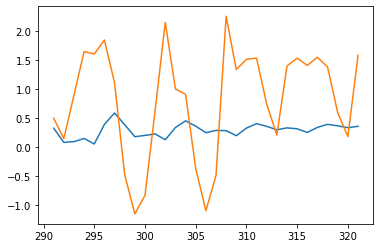

In [ ]:
plt.plot(df_results.iloc[:,7])
plt.plot(df_test.iloc[:,3])

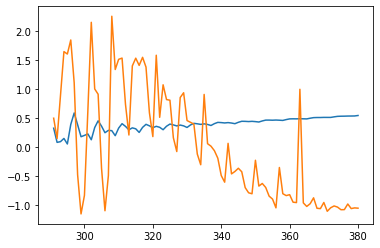

In [ ]:
plt.plot(df_results_long.iloc[:,7])
plt.plot(df_test_long.iloc[:,3])

In [ ]:
mse_var_short = mean_squared_error(df_results.iloc[:,7], df_test.iloc[:,3])
print(mse_var_short)

mape_var_short = mape_unscaled(df_results.iloc[:,7], df_test.iloc[:,3])
print(mape_var_short)

1.130130329260515
0.615972580158558


In [ ]:
mse_var_long = mean_squared_error(df_results_long.iloc[:,7], df_test_long.iloc[:,3])
print(mse_var_long)

mape_var_long = mape_unscaled(df_results_long.iloc[:,7], df_test_long.iloc[:,3])
print(mape_var_long)

1.2031081156766918
0.5939145735245616


# AutoRegression (not use)

In [ ]:
df = pd.DataFrame(cdc_scaled[:, :4])

series_train = df.iloc[:291, 3]
series_test = np.array(df.iloc[291:322, 3])
series_test_long = np.array(df.iloc[291:381, 3])

series_differenced = np.array(series_train.diff().dropna())

# Check size
print(series_train.shape)
print(series_test.shape)

(291,)
(31,)


In [ ]:
from statsmodels.tsa.arima_model import ARIMA

arima_model = ARIMA(np.array(df_train.iloc[:,3]), order = (1,1,2))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  290
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -198.999
Method:                       css-mle   S.D. of innovations              0.480
Date:                Wed, 08 Jun 2022   AIC                            407.997
Time:                        23:53:03   BIC                            426.346
Sample:                             1   HQIC                           415.349
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.007      0.567      0.571      -0.010       0.018
ar.L1.D.y     -0.3253      0.395     -0.825      0.410      -1.099       0.448
ma.L1.D.y     -0.3410      0.379     -0.899      0.370      -1.085       0.403
ma.L2.D.y     -0.3312      0.280     -1.183      0.238      -0.880       0.218
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.0743           +0.0000j            3.0743            0.5000
MA.1            1.2975           +0.0000j            1.2975            0.0000
MA.2           -2.3271           +0.0000j            2.3271            0.5000
-----------------------------------------------------------------------------
"""

In [ ]:
def arima_predict(train, test):
  history = [x for x in train]
  predictions = list()
  # walk-forward validation

  for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

  return predictions


14664181933.826546
1.1979720640529872


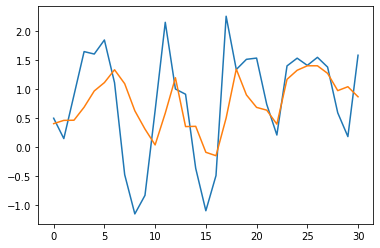

In [ ]:
predictions = arima_predict(series_train, series_test)

plt.plot(series_test)
plt.plot(predictions)
mse_ar_short = mse_unscaled(series_test,predictions)
mape_ar_short = mape_unscaled(series_test,predictions)

print(mse_ar_short)
print(mape_ar_short)

7780049107.813217
0.7246037916879514


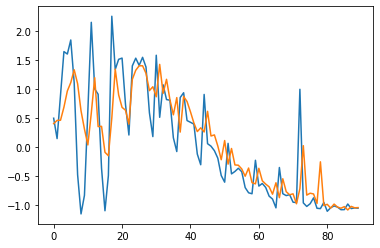

In [ ]:
predictions_long = arima_predict(series_train, series_test_long)

plt.plot(series_test_long)
plt.plot(predictions_long)
mse_ar_long = mse_unscaled(series_test_long, predictions_long)
print(mse_ar_long)
mape_ar_long = mape_unscaled(series_test_long, predictions_long)
print(mape_ar_long)

# Transformer Keras

## functions

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)

    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

class PositionEmbeddingFixedWeights(Layer):
    def __init__(self, sequence_length, dimen, **kwargs):
        super(PositionEmbeddingFixedWeights, self).__init__(**kwargs)

        position_embedding_matrix = self.get_position_encoding(sequence_length, dimen)

        self.position_embedding_layer = Embedding(
            input_dim=sequence_length, output_dim=dimen,
            weights=[position_embedding_matrix],
            trainable=False
        )

    def get_position_encoding(self, seq_len, d, n=10000):
        P = np.zeros((seq_len, d))
        for i in np.arange(int(seq_len/2)):
            for k in range(d):
                denominator = np.power(n, 2*i/d)
                P[2*i, k] = np.sin(k/denominator)
                P[2*i+1, k] = np.cos(k/denominator)
        return P

    def call(self, inputs):
        position_indices = tf.range(tf.shape(inputs)[0])
        embedded_indices = self.position_embedding_layer(position_indices)
        return inputs + embedded_indices


def build_model(
    input_shape,  # shape of an X instance
    head_size,  #
    num_heads,
    ff_dim, # number of filters
    num_transformer_blocks, # number of encoder blocks
    mlp_units,  # number of MLP layers
    dropout=0,  #dropout rate for encoder
    mlp_dropout=0,  # dropout rate for MLP layers
):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    print(x.shape)

    pe = PositionEmbeddingFixedWeights(input_shape[0], input_shape[1])
    x = pe(x)
    print(x.shape)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(number_to_predict, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

### try one

In [ ]:

seed(42)
set_seed(42)

one_model = build_model(
    input_shape,
    head_size = 512,
    num_heads = 4,
    ff_dim = 8,
    num_transformer_blocks = 8,
    mlp_units = [128],
    mlp_dropout = 0.3,
    dropout = 0.25,
)

one_model.compile(
    loss = MeanSquaredError(),
    optimizer = keras.optimizers.Adam(learning_rate=1e-4),
    metrics = [MeanSquaredError()],
)

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

one_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs = 200,
    batch_size = 2,
    callbacks=callbacks,
    verbose = 0
)


## grid search

In [ ]:
from pandas.core.sorting import decons_obs_group_ids
### Grid Search

head_size_list = [256, 512]
num_heads_list = [4,8]
filter_dim_list = [4,8]
num_transformer_blocks_list = [4, 6, 8]
mlp_list = [
        [128],
        [128,64,32,16],
        [128,64,32],
        [64,32],
        [32]
]
mlp_dropout_list = [0.3]
dropout_list = [0.25]


result_list = []

for head_size in head_size_list:
  for num_heads in num_heads_list:
    for ff_dim in filter_dim_list:
      for num_transformer_blocks in num_transformer_blocks_list:
        for mlp_units in mlp_list:
          for mlp_dropout in mlp_dropout_list:
            for dropout in dropout_list:

              seed(42)
              set_seed(42)

              model = build_model(
                        input_shape,
                        head_size = head_size,
                        num_heads = num_heads,
                        ff_dim = ff_dim,
                        num_transformer_blocks = num_transformer_blocks,
                        mlp_units = mlp_units,
                        mlp_dropout = mlp_dropout,
                        dropout = dropout,
                    )
              model.compile(
                  loss = MeanSquaredError(),
                  optimizer = keras.optimizers.Adam(learning_rate=1e-4),
                  metrics = [MeanSquaredError()],
              )

              callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

              model.fit(
                  X_train,
                  y_train,
                  validation_split=0.2,
                  epochs= 100,
                  batch_size=8,
                  callbacks=callbacks,
                  verbose = 0
              )

              result_short = model.evaluate(X_test_short, y_test_short, verbose=0)
              result_long = model.evaluate(X_test_long, y_test_long, verbose=0)

              result_list.append([head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, mlp_dropout, dropout, round(result_short[0], 4), round(result_long[0], 4)])

              print('head_size:', head_size, ' num_heads:', num_heads, ' ff_dim:', ff_dim, ' num_transformer_blocks:', num_transformer_blocks,
                    ' mlp_units:', mlp_units, ' mlp_dropout:', mlp_dropout, ' dropout:', dropout)

              print('Result_short:', result_short[0], ' Result_long:', result_long[0])
              print(' ')

result_list = pd.DataFrame(result_list)
result_list.columns = ['head_size', 'num_heads', 'ff_dim', 'num_transformer_blocks', 'mlp_units', 'mlp_dropout', 'dropout', 'result_short', 'result_long']
result_list

### result 1

In [ ]:
result_list1 = pd.DataFrame(result_list)
result_list1.columns = ['head_size', 'num_heads', 'ff_dim', 'num_transformer_blocks', 'mlp_units', 'mlp_dropout', 'dropout', 'result_short', 'result_long']

result_list1.to_csv('/content/drive/MyDrive/Tilburg Thesis/LSTMgridsearch1.csv')
result_list1

,head_size,num_heads,ff_dim,num_transformer_blocks,mlp_units,mlp_dropout,dropout,result_short,result_long
0,256,4,4,4,[128],0.3,0.25,0.3586,1.0123
1,256,4,4,4,"[128, 64, 32, 16]",0.3,0.25,0.3922,1.0318
2,256,4,4,4,"[128, 64, 32]",0.3,0.25,0.3772,1.0940
3,256,4,4,4,"[64, 32]",0.3,0.25,0.3552,1.0231
4,256,4,4,4,[32],0.3,0.25,0.3512,0.9431
...,...,...,...,...,...,...,...,...,...
115,512,8,8,8,[128],0.3,0.25,0.2931,0.6770
116,512,8,8,8,"[128, 64, 32, 16]",0.3,0.25,0.4253,0.8973
117,512,8,8,8,"[128, 64, 32]",0.3,0.25,0.6673,1.0946
118,512,8,8,8,"[64, 32]",0.3,0.25,0.5316,0.9607


### result 2

In [ ]:
result_list2 = pd.DataFrame(result_list)
result_list2.columns = ['head_size', 'num_heads', 'ff_dim', 'num_transformer_blocks', 'mlp_units', 'mlp_dropout', 'dropout', 'result_short', 'result_long']
result_list2

### result 3

In [ ]:
result_list3 = pd.DataFrame(result_list)
result_list3.columns = ['head_size', 'num_heads', 'ff_dim', 'num_transformer_blocks', 'mlp_units', 'mlp_dropout', 'dropout', 'result_short', 'result_long']
result_list3

## Get Best model

### best short

In [ ]:

best_model_short_setting = {
    'head_size': 512,
    'num_heads': 8,
    'ff_dim': 4,
    'num_transformer_blocks': 6,
    'mlp_units': [32],
    'mlp_dropout': 0.3,
    'dropout': 0.25
}

seed(42)
set_seed(42)

best_model_short = build_model(
    input_shape,
    head_size = best_model_short_setting['head_size'],
    num_heads = best_model_short_setting['num_heads'],
    ff_dim = best_model_short_setting['ff_dim'],
    num_transformer_blocks = best_model_short_setting['num_transformer_blocks'],
    mlp_units = best_model_short_setting['mlp_units'],
    mlp_dropout = best_model_short_setting['mlp_dropout'],
    dropout = best_model_short_setting['dropout'],
)

best_model_short.compile(
    loss = MeanSquaredError(),
    optimizer = keras.optimizers.Adam(learning_rate=1e-4),
    metrics = [MeanSquaredError()],
)

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

best_model_short.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs = 200,
    batch_size=8,
    callbacks=callbacks,
    verbose = 0
)

y_pred_short = best_model_short.predict(X_test_short)
print('MSE test for best model of short is: ', mse_unscaled(y_pred_short, y_test_short))


MSE test for best model of short is:  0.26923696088541144


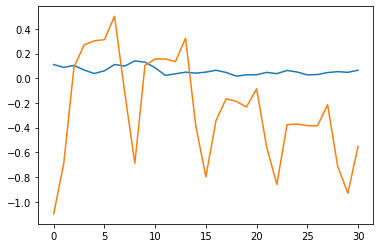

In [ ]:
plt.plot(y_pred_short)
plt.plot(y_test_short)

In [ ]:
best_model_short.evaluate(X_test_short, y_test_short, verbose = 1)

1/1 [==============================] - 0s 90ms/step - loss: 0.6995 - mean_squared_error: 0.6995


[0.6994537711143494, 0.6994537711143494]

### best long

In [ ]:
best_model_long_setting = {
    'head_size': 512,
    'num_heads': 4,
    'ff_dim': 8,
    'num_transformer_blocks': 8,
    'mlp_units': [128],
    'mlp_dropout': 0.3,
    'dropout': 0.25
}

seed(42)
set_seed(42)

best_model_long = build_model(
    input_shape,
    head_size = best_model_long_setting['head_size'],
    num_heads = best_model_long_setting['num_heads'],
    ff_dim = best_model_long_setting['ff_dim'],
    num_transformer_blocks = best_model_long_setting['num_transformer_blocks'],
    mlp_units = best_model_long_setting['mlp_units'],
    mlp_dropout = best_model_long_setting['mlp_dropout'],
    dropout = best_model_long_setting['dropout'],
)

best_model_long.compile(
    loss = MeanSquaredError(),
    optimizer = keras.optimizers.Adam(learning_rate=1e-4),
    metrics = [MeanSquaredError()],
)

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

best_model_long.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs = 200,
    batch_size = 2,
    callbacks=callbacks,
    verbose = 0
)

y_pred_long = best_model_long.predict(X_test_long)
print('MSE test for best model of long is: ', mse_unscaled(y_pred_long, y_test_long))


MSE test for best model of long is:  0.6369060312130603


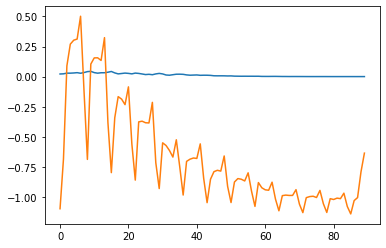

In [ ]:
plt.plot(y_pred_long)
plt.plot(y_test_long)

## Save model

In [ ]:
# save model

from google.colab import drive
drive.mount('/content/drive/')

model.save('/content/drive/MyDrive/my_model')

Mounted at /content/drive/


INFO:tensorflow:Assets written to: /content/drive/MyDrive/my_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/my_model/assets


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/my_model')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# LSTM

## functions

In [ ]:
from tensorflow.keras.layers import Bidirectional, Conv1D, MaxPooling1D

def buildManyToOneModel(shape):
    model = Sequential()  # 别改
    model.add(LSTM(10, input_length=shape[1], input_dim=shape[2]))

    model.add(Dense(10, activation = "relu"))
    model.add(Dense(5, activation = "relu"))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam", metrics = ['mean_squared_error']) # 别改
    model.summary()
    return model

def buildManyToOneModel_stack(shape):
    model = Sequential()  # 别改
    model.add(LSTM(10, input_length=shape[1], input_dim=shape[2], return_sequences = True))
    model.add(LSTM(10))

    model.add(Dense(10, activation = "relu"))
    model.add(Dense(5, activation = "relu"))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam", metrics = ['mean_squared_error']) # 别改
    model.summary()
    return model

def buildManyToOneModel_bistack(shape):
    model = Sequential()  # 别改
    model.add(Bidirectional(LSTM(10, input_length=shape[1], input_dim=shape[2], return_sequences = True)))
    model.add(Bidirectional(LSTM(10)))

    model.add(Dense(10, activation = "relu"))
    model.add(Dense(5, activation = "relu"))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam", metrics = ['mean_squared_error']) # 别改
    model.build((None, shape[1], shape[2]))
    model.summary()
    return model


def buildManyToOneModel_cnnstack(shape):

    model = Sequential()

    model.add(Conv1D(3, 3, input_shape=shape[1:]))
    model.add(MaxPooling1D(2))

    model.add(LSTM(10, return_sequences = True))
    model.add(LSTM(10))

    model.add(Dense(10, activation = "relu"))
    model.add(Dense(5, activation = "relu"))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam", metrics = ['mean_squared_error']) # 别改
    model.summary()

    return model


def buildManyToOneModel_cnnsimple(shape):

    model = Sequential()

    model.add(Conv1D(3, 3, input_shape=shape[1:]))
    model.add(MaxPooling1D(2))

    model.add(LSTM(10))

    model.add(Dense(10, activation = "relu"))
    model.add(Dense(5, activation = "relu"))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam", metrics = ['mean_squared_error']) # 别改
    model.summary()

    return model

In [ ]:
def create_sequences(X, y, seq_length):
    xs = np.zeros([len(X)-seq_length+1, seq_length, X.shape[1]])
    ys = np.zeros([len(X)-seq_length+1, seq_length])

    for i in range(len(X)-seq_length+1):
        xs[i,:,:] = X[i:(i+seq_length), :]
        ys[i,:] = y[i:(i+seq_length)]

    return xs, ys

def mda(actual: np.ndarray, predicted: np.ndarray):
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

def mse(actual: np.ndarray, predicted: np.ndarray):
    return np.mean(np.square(actual - predicted))

def mape(actual: np.ndarray, predicted: np.ndarray):
    return np.mean(np.abs(actual - predicted))

def rmse(actual: np.ndarray, predicted: np.ndarray):
    return np.sqrt(mse(actual, predicted))

## train

In [ ]:

X_train_lstm, X_val, y_train_lstm, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)


print(X_train_lstm.shape)
print(X_val.shape)

print(y_train_lstm.shape)
print(y_val.shape)


print(X_test_long.shape)
print(y_test_long.shape)

print(X_test_short.shape)
print(y_test_short.shape)

(261, 14, 3)
(30, 14, 3)
(261,)
(30,)
(90, 14, 3)
(90,)
(31, 14, 3)
(31,)


In [ ]:
seed(42)
set_seed(42)

model_simple_rate = buildManyToOneModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=0, mode="auto")
model_simple_rate.fit(X_train, y_train, epochs=200, batch_size=8, validation_data=(X_val, y_val), callbacks=[callback])
pre_test_simple_rate_long = model_simple_rate.predict(X_test_long)
pre_test_simple_rate_short = model_simple_rate.predict(X_test_short)


seed(42)
set_seed(42)

model_stack_rate = buildManyToOneModel_stack(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=0, mode="auto")
model_stack_rate.fit(X_train, y_train, epochs=200, batch_size=8, validation_data=(X_val, y_val), callbacks=[callback])
pre_test_stack_rate_long = model_stack_rate.predict(X_test_long)
pre_test_stack_rate_short = model_stack_rate.predict(X_test_short)


seed(42)
set_seed(42)

model_bistack_rate = buildManyToOneModel_bistack(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=0, mode="auto")
model_bistack_rate.fit(X_train, y_train, epochs=200, batch_size=8, validation_data=(X_val, y_val), callbacks=[callback])
pre_test_bistack_rate_long = model_bistack_rate.predict(X_test_long)
pre_test_bistack_rate_short = model_bistack_rate.predict(X_test_short)


seed(42)
set_seed(42)

model_cnnstack_rate = buildManyToOneModel_cnnstack(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=0, mode="auto")
model_cnnstack_rate.fit(X_train, y_train, epochs=200, batch_size=8, validation_data=(X_val, y_val), callbacks=[callback])
pre_test_cnnstack_rate_long = model_cnnstack_rate.predict(X_test_long)
pre_test_cnnstack_rate_short = model_cnnstack_rate.predict(X_test_short)


seed(42)
set_seed(42)

model_cnnsimple_rate = buildManyToOneModel_cnnsimple(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=0, mode="auto")
model_cnnsimple_rate.fit(X_train, y_train, epochs=200, batch_size=8, validation_data=(X_val, y_val), callbacks=[callback])
pre_test_cnnsimple_rate_long = model_cnnsimple_rate.predict(X_test_long)
pre_test_cnnsimple_rate_short = model_cnnsimple_rate.predict(X_test_short)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                560       
                                                                 
 dense (Dense)               (None, 10)                110       
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 731
Trainable params: 731
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
37/37 [==============================] - 6s 26ms/step - loss: 0.9760 - mean_squared_error: 0.9760 - val_loss: 0.5722 - val_mean_squared_error: 0.5722
Epoch 2/200
37/37 [=========

## predict

In [ ]:
mse_lstm_stack_long = mean_squared_error(pre_test_stack_rate_long, y_test_long)
print(mse_lstm_stack_long)

mape_lstm_stack_long = mape_unscaled(pre_test_stack_rate_long, y_test_long)
print(mape_lstm_stack_long)

mse_lstm_stack_short = mean_squared_error(pre_test_stack_rate_short, y_test_short)
print(mse_lstm_stack_short)

mape_lstm_stack_short = mape_unscaled(pre_test_stack_rate_short, y_test_short)
print(mape_lstm_stack_short)

0.5782450777654133
0.8376990914484354
0.36857473610512215
1.1562249007797496


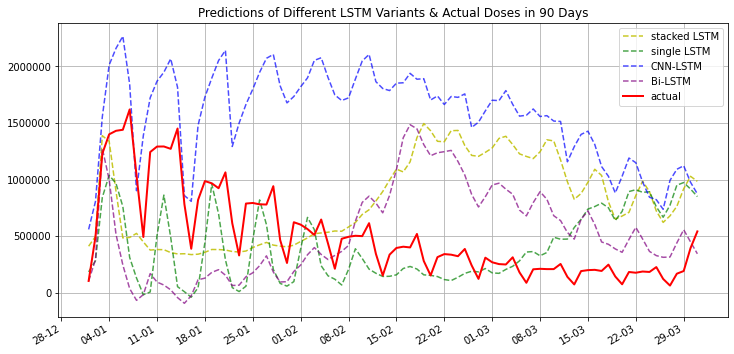

In [ ]:
plt.figure(figsize=(12,6))
plt.ticklabel_format(style='plain', axis = 'y')

plt.plot(test_long_dates, scale_back(pre_test_stack_rate_long), 'y--', label = 'stacked LSTM', alpha = 0.85)
plt.plot(test_long_dates, scale_back(pre_test_simple_rate_long), 'g--', label = 'single LSTM', alpha = 0.7)
plt.plot(test_long_dates, scale_back(pre_test_cnnsimple_rate_long), 'b--', label = 'CNN-LSTM', alpha = 0.7)
plt.plot(test_long_dates, scale_back(pre_test_bistack_rate_long), '--', color = 'purple', label = 'Bi-LSTM', alpha = 0.7)

plt.plot(test_long_dates, scale_back(y_test_long), 'r-', label = 'actual', linewidth = 2)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.gcf().autofmt_xdate()

plt.grid()
plt.title('Predictions of Different LSTM Variants & Actual Doses in 90 Days')
plt.legend()

In [ ]:
mse_lstm_simple_short = mean_squared_error(pre_test_simple_rate_short, y_test_short)
print(mse_lstm_simple_short)

mape_lstm_simple_short = mape_unscaled(pre_test_simple_rate_short, y_test_short)
print(mape_lstm_simple_short)

mse_lstm_simple_long = mean_squared_error(pre_test_simple_rate_long, y_test_long)
print(mse_lstm_simple_long)

mape_lstm_simple_long = mape_unscaled(pre_test_simple_rate_long, y_test_long)
print(mape_lstm_simple_long)

0.1280119713123996
0.3757124576490579
0.458433540710593
0.5553770329395682


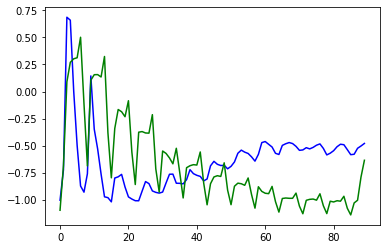

In [ ]:
plt.plot(pre_test_bistack_rate_long, 'b-')
plt.plot(y_test_long, 'g-')

In [ ]:
mse_lstm_bistack_long = mean_squared_error(pre_test_bistack_rate_long, y_test_long)
print(mse_lstm_bistack_long)

mape_lstm_bistack_long = mape_unscaled(pre_test_bistack_rate_long, y_test_long)
print(mape_lstm_bistack_long)

mse_lstm_bistack_short = mean_squared_error(pre_test_bistack_rate_short, y_test_short)
print(mse_lstm_bistack_short)

mape_lstm_bistack_short = mape_unscaled(pre_test_bistack_rate_short, y_test_short)
print(mape_lstm_bistack_short)

0.2239956641999469
0.8864390324965014
0.37569665985784434
1.5331759330100743


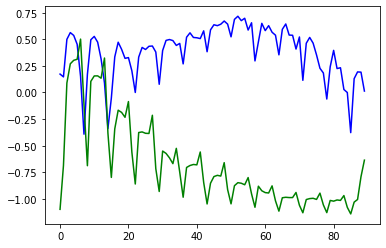

In [ ]:
plt.plot(pre_test_cnnstack_rate_long, 'b-')
plt.plot(y_test_long, 'g-')

In [ ]:
mse_lstm_cnnstack_long = mean_squared_error(pre_test_cnnstack_rate_long, y_test_long)
print(mse_lstm_cnnstack_long)

mape_lstm_cnnstack_long = mape_unscaled(pre_test_cnnstack_rate_long, y_test_long)
print(mape_lstm_cnnstack_long)

mse_lstm_cnnstack_short = mean_squared_error(pre_test_cnnstack_rate_short, y_test_short)
print(mse_lstm_cnnstack_short)

mape_lstm_cnnstack_short = mape_unscaled(pre_test_cnnstack_rate_short, y_test_short)
print(mape_lstm_cnnstack_short)

1.3432767409392667
0.672227384597326
0.4388037707378957
0.40241727720476794


In [ ]:
mse_lstm_cnnsimple_long = mean_squared_error(pre_test_cnnsimple_rate_long, y_test_long)
print(mse_lstm_cnnsimple_long)

mape_lstm_cnnsimple_long = mape_unscaled(pre_test_cnnsimple_rate_long, y_test_long)
print(mape_lstm_cnnsimple_long)

mse_lstm_cnnsimple_short = mean_squared_error(pre_test_cnnsimple_rate_short, y_test_short)
print(mse_lstm_cnnsimple_short)

mape_lstm_cnnsimple_short = mape_unscaled(pre_test_cnnsimple_rate_short, y_test_short)
print(mape_lstm_cnnsimple_short)

1.1031001220359384
0.6496847786904142
0.6134051184195471
0.41851912036915956


# Results

In [ ]:

# ar_results = np.array([mse_ar_short, mse_ar_long, mape_ar_short, mape_ar_long])
var_results = np.array([mse_var_short, mse_var_long, mape_var_short, mape_var_long])
lstm_stack_results = np.array([mse_lstm_stack_short, mse_lstm_stack_long, mape_lstm_stack_short, mape_lstm_stack_long])
lstm_simple_results = np.array([mse_lstm_simple_short, mse_lstm_simple_long, mape_lstm_simple_short, mape_lstm_simple_long])
lstm_bistack_results = np.array([mse_lstm_bistack_short, mse_lstm_bistack_long, mape_lstm_bistack_short, mape_lstm_bistack_long])
lstm_cnnsimple_results = np.array([mse_lstm_cnnsimple_short, mse_lstm_cnnsimple_long, mape_lstm_cnnsimple_short, mape_lstm_cnnsimple_long])
transformer_results = np.array([mse_transformer_short, mse_transformer_long, mape_transformer_short, mape_transformer_long])


results = np.vstack([
            var_results,
            lstm_stack_results,
            lstm_simple_results,
            lstm_bistack_results,
            lstm_cnnsimple_results,
            transformer_results
            ])
row_index = [ 'VAR', 'LSTM_stack', 'LSTM_simple', 'LSTM_bistack', 'LSTM_cnnsimple', 'Transformer']
results = pd.DataFrame(results, index = row_index)
results.columns = ['MSE_short', 'MSE_long', 'MAPE_short', 'MAPE_long']
results

,MSE_short,MSE_long,MAPE_short,MAPE_long
VAR,0.401807,0.856860,0.326657,0.576386
LSTM_stack,0.273140,0.202841,0.732903,0.587512
LSTM_simple,0.128012,0.458434,0.375712,0.555377
LSTM_bistack,0.375697,0.223996,1.533176,0.886439
LSTM_cnnsimple,0.613405,1.103100,0.418519,0.649685
Transformer,0.104732,0.055617,0.236921,0.322017


In [ ]:
# MSE_short, MSE_long, MAPE_short, MAPE_long, epoch

